<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages



<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [29]:
import datetime

In [119]:
import sys
sys.path.append("../STOCK_DRL")

import warnings
warnings.filterwarnings("ignore")

from finrl.main import check_and_make_directories

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

from Processed import get_processed_data

from  module.yahoodownloader import YahooDownloader
from module.preprocessor import FeatureEngineer, data_split
from module.efficient_frontier import EfficientFrontier
from module import helper
from module.config_tickers import DOW_30_TICKER
from module.env_stocktrading import StockTradingEnv
from module.models import DRLAgent
from module.logger import configure
from module.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
    
)


<a id='1.4'></a>
## 2.4. Create Folders

In [31]:
from finrl.main import check_and_make_directories
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [32]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-01'

In [33]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [34]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [35]:
df.shape

(103961, 8)

In [36]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758535,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832630,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.365313,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579332,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [37]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3551, 8)
Successfully added vix
Successfully added turbulence index


In [38]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [39]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758535,746015200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,2.758535,2.758535,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.832630,6547900.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,43.832630,43.832630,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365313,10955700.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,15.365313,15.365313,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579332,7117200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,31.579332,31.579332,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.948335,40980600.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,11.948335,11.948335,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,43.677174,13695900.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,43.677174,43.677174,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597498,9796600.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,20.597498,20.597498,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,69.747604,14088500.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,69.747604,69.747604,39.189999,0.0


In [40]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [41]:
mvo_df

,date,tic,close
0,2009-01-02,AAPL,2.758535
1,2009-01-02,AMGN,43.832630
2,2009-01-02,AXP,15.365313
3,2009-01-02,BA,33.941101
4,2009-01-02,CAT,31.579332
...,...,...,...
102974,2023-02-09,UNH,485.730011
102975,2023-02-09,V,229.350006
102976,2023-02-09,VZ,39.810001
102977,2023-02-09,WBA,35.342278


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [42]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
19082


In [43]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,284.978668,2932900.0,1.0,-0.019292,300.970776,268.613870,52.413026,-25.915050,1.846804,285.220247,278.269251,30.43,12.918785
2892,2020-06-30,V,191.490005,193.750000,190.160004,189.604050,9040100.0,1.0,1.042560,197.569689,183.942025,53.021046,-51.607982,2.013358,190.347372,180.598286,30.43,12.918785
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,48.169010,17414800.0,1.0,-0.417954,51.555482,46.593790,48.097039,-51.186707,8.508886,48.776546,49.209270,30.43,12.918785
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,37.630482,4782100.0,1.0,-0.080962,41.075404,35.173596,48.830182,-14.613199,1.500723,37.726358,37.533499,30.43,12.918785
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,115.184021,6836400.0,1.0,-0.879409,118.508925,112.593778,48.159692,-69.964569,3.847271,116.836411,118.756425,30.43,12.918785


In [44]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494560,110737200.0,2.0,3.000855,92.276537,79.814264,62.807147,107.499034,29.730532,83.550962,77.363088,28.620001,53.068048
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,234.614319,6575800.0,2.0,3.552512,227.036702,195.594638,61.279649,270.849132,46.806139,209.902517,210.950769,28.620001,53.068048
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078468,3301000.0,2.0,-0.384903,109.215325,86.798780,48.504818,-66.306144,3.142448,96.180266,89.702836,28.620001,53.068048
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068048
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455795,2807800.0,2.0,1.249468,128.246924,111.290120,52.865424,35.692997,14.457404,117.239535,111.578317,28.620001,53.068048


In [45]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [46]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [47]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [48]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [49]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [50]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


2023-02-23 15:17:04.267748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 15:17:05.436399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/acraf/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-23 15:17:05.436509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/acraf/.local/lib/python3.8/site-packages/cv2/../../lib64:
20

Logging to results/a2c


In [51]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 99         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.197     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -98.3      |
|    reward             | 0.06059996 |
|    std                | 1.01       |
|    value_loss         | 5.83       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 100        |
|    iterations         | 200        |
|    time_elapsed       | 9          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      |

### Agent 2: DDPG

In [52]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [53]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3941423.47
total_reward: 2941423.47
total_cost: 6649.37
total_trades: 49178
Sharpe: 0.741
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 51       |
|    time_elapsed    | 225      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 22.3     |
|    critic_loss     | 256      |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 5.898233 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 46       |
|    time_elapsed    | 492      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | -0.116   |
|    critic_loss     | 6.07     |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward          | 5

### Agent 3: PPO

In [54]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [55]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 109        |
|    iterations      | 1          |
|    time_elapsed    | 18         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.05693112 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 2           |
|    time_elapsed         | 38          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015458433 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00368     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.87        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0284     |
|   

### Agent 4: TD3

In [56]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [57]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

day: 2892, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 4227538.79
total_reward: 3227538.79
total_cost: 999.00
total_trades: 49164
Sharpe: 0.789
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 56        |
|    time_elapsed    | 204       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 19.6      |
|    critic_loss     | 1.1e+03   |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 5.7183347 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 54        |
|    time_elapsed    | 420       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 27.7      |
|    critic_loss     | 43        |
|    learning_rate   | 0.001     |
|    n_updates       | 20251     |
|

### Agent 5: SAC

In [58]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [59]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 41        |
|    time_elapsed    | 278       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 484       |
|    critic_loss     | 96.7      |
|    ent_coef        | 0.114     |
|    ent_coef_loss   | -98.2     |
|    learning_rate   | 0.0001    |
|    n_updates       | 11471     |
|    reward          | 2.8021646 |
----------------------------------
day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 6293377.60
total_reward: 5293377.60
total_cost: 26264.12
total_trades: 49427
Sharpe: 0.799
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 42         |
|    time_elapsed    | 550        |
|    total_timesteps | 23144      |
| train/             |            |
|    actor_loss      | 260        |
|    critic_loss     | 614

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [60]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [61]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [62]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [63]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567960
std        43.790812
min         0.000000
25%        14.962939
50%        24.124536
75%        39.162636
max       652.502841
Name: turbulence, dtype: float64

In [64]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45097654551677

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [65]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [66]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494560,110737200.0,2.0,3.000855,92.276537,79.814264,62.807147,107.499034,29.730532,83.550962,77.363088,28.620001,53.068048
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,234.614319,6575800.0,2.0,3.552512,227.036702,195.594638,61.279649,270.849132,46.806139,209.902517,210.950769,28.620001,53.068048
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078468,3301000.0,2.0,-0.384903,109.215325,86.798780,48.504818,-66.306144,3.142448,96.180266,89.702836,28.620001,53.068048
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068048
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455795,2807800.0,2.0,1.249468,128.246924,111.290120,52.865424,35.692997,14.457404,117.239535,111.578317,28.620001,53.068048


In [67]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [68]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [69]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [70]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [71]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [72]:
df_account_value_a2c.shape

(658, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [73]:
mvo_df.head()

,date,tic,close
0,2009-01-02,AAPL,2.758535
1,2009-01-02,AMGN,43.832630
2,2009-01-02,AXP,15.365313
3,2009-01-02,BA,33.941101
4,2009-01-02,CAT,31.579332


In [74]:
mvo_df

,date,tic,close
0,2009-01-02,AAPL,2.758535
1,2009-01-02,AMGN,43.832630
2,2009-01-02,AXP,15.365313
3,2009-01-02,BA,33.941101
4,2009-01-02,CAT,31.579332
...,...,...,...
102974,2023-02-09,UNH,485.730011
102975,2023-02-09,V,229.350006
102976,2023-02-09,VZ,39.810001
102977,2023-02-09,WBA,35.342278


In [75]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [76]:
mvo.shape[0]

3551

In [77]:
mvo

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2009-01-02,2.758535,43.832630,15.365313,33.941101,31.579332,8.505000,11.948335,43.677174,20.597498,69.747604,...,17.947054,15.162149,11.144299,41.015415,32.030643,22.703108,12.079290,16.240593,17.517084,41.618885
2009-01-05,2.874956,44.323036,15.858145,34.631165,31.020578,8.337500,12.054013,43.757114,20.235832,71.371536,...,17.674952,15.303854,11.224111,40.721516,31.555840,22.332808,12.165181,15.227901,18.401514,41.138496
2009-01-06,2.827537,43.349655,16.748417,34.736183,30.832092,8.650000,12.533074,44.150955,20.933325,71.315262,...,17.350748,15.482845,10.997278,40.603954,30.592081,21.806177,13.021847,14.984102,18.312384,40.774586
2009-01-07,2.766438,43.245609,16.042889,33.573559,29.398191,8.000000,12.201958,42.215965,19.960287,67.930779,...,17.072861,14.550591,10.598219,39.892052,29.380308,21.641596,12.739307,15.174374,18.531775,40.425213
2009-01-08,2.817809,44.033237,16.066942,33.596066,29.633808,8.227500,12.356948,42.375774,19.719177,68.662300,...,16.997597,15.005535,10.793549,39.454479,29.925964,21.978971,12.603684,15.407461,18.401514,37.397324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-03,154.264465,243.026794,178.860001,206.009995,247.759995,171.039993,48.630001,167.965149,110.709999,369.950012,...,102.940002,257.704529,127.610001,142.610001,182.759995,472.019989,229.680145,41.509998,36.605560,141.710007
2023-02-06,151.498688,241.718353,176.479996,206.809998,251.419998,169.050003,47.570000,168.153488,109.870003,370.799988,...,104.029999,256.128448,125.730003,141.399994,185.990005,475.239990,228.991501,41.279999,35.806137,140.679993
2023-02-07,154.414230,241.867035,178.699997,214.759995,249.660004,171.279999,47.840000,172.564484,111.629997,374.399994,...,105.680000,266.891510,125.330002,140.020004,189.009995,476.880005,230.867828,40.549999,36.260132,140.979996
2023-02-08,151.688400,238.100250,179.000000,213.500000,248.869995,169.630005,46.959999,168.510330,111.779999,375.100006,...,106.639999,266.063599,122.910004,138.570007,187.389999,483.220001,229.750000,40.520000,36.082481,140.220001


### Helper functions

In [78]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  
    
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [79]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [80]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 3551  #excluding header 
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size


#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-658)
TradeData = mvo.tail(658)
# df.head()
TradeData.to_numpy()


array([[ 89.49456024, 234.61431885,  91.07846832, ...,  47.76708603,
         36.29003525, 115.09745789],
       [ 89.49456024, 237.48356628,  91.34963226, ...,  47.8719368 ,
         37.26651382, 114.63588715],
       [ 91.88857269, 235.65350342,  93.52852631, ...,  48.26512146,
         38.31402969, 114.32815552],
       ...,
       [154.41423035, 241.86703491, 178.69999695, ...,  40.54999924,
         36.26013184, 140.97999573],
       [151.68840027, 238.10025024, 179.        , ...,  40.52000046,
         36.08248138, 140.22000122],
       [150.63999939, 237.9019928 , 179.36999512, ...,  39.81000137,
         35.34227753, 141.52000427]])

In [81]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

In [82]:
from module.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [83]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2020-06-30,89.664169,216.902405,91.775711,183.300003,118.869247,187.330002,42.848259,78.808456,111.510002,187.060196,...,67.950188,198.444717,95.878029,111.77137,107.692009,284.978668,189.60405,48.16901,37.630482,115.184021


In [84]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4731.544,    0.   ,    0.   ,    0.   ,    0.   ,  579.993,
          0.   ,    0.   ,    0.   ,    0.   ,  766.211,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   85.465,    0.   ,    0.   ,    0.   ,
        468.596,  712.801,    0.   ,    0.   ,    0.   ])

In [85]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2020-07-01,1.001917e+06
2020-07-02,1.004235e+06
2020-07-06,1.023225e+06
2020-07-07,1.014021e+06
2020-07-08,1.029461e+06
...,...
2023-02-03,1.490038e+06
2023-02-06,1.474972e+06
2023-02-07,1.489968e+06
2023-02-08,1.474838e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [86]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var']

<Figure size 1500x500 with 0 Axes>

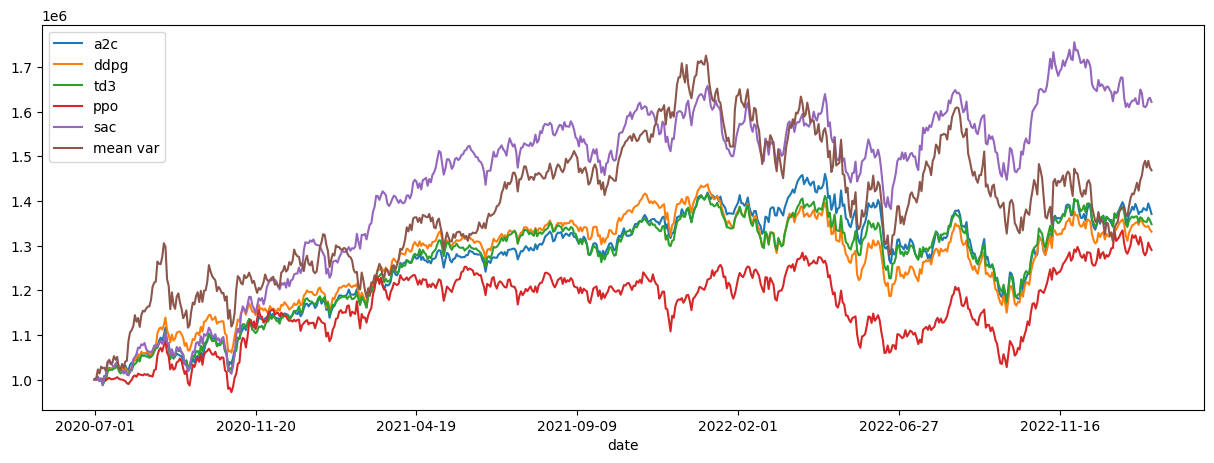

In [121]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()
plt.savefig("trained_models/models_" + str(datetime.datetime.now()) + ".jpg")

In [123]:
result.tail(1)

,a2c,ddpg,td3,ppo,sac,mean var
date,,,,,,
2023-02-09,1.371005e+06,1.331448e+06,1.348161e+06,1.290511e+06,1.621898e+06,1.468825e+06


In [125]:
unique_trade_date = processed[(processed.date > TRADE_START_DATE)&(processed.date <= TRADE_END_DATE)].date.unique()

In [133]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value = df_account_value_sac)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.203468
Cumulative returns     0.621898
Annual volatility      0.177842
Sharpe ratio           1.132101
Calmar ratio           1.224286
Stability              0.699766
Max drawdown          -0.166193
Omega ratio            1.204768
Sortino ratio          1.703493
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.098762
Daily value at risk   -0.021607
dtype: float64


In [136]:
def get_baseline(ticker, start, end):
    return YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()

baseline_df = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (658, 8)
Annual return          0.108788
Cumulative returns     0.309497
Annual volatility      0.164130
Sharpe ratio           0.712314
Calmar ratio           0.495826
Stability              0.243378
Max drawdown          -0.219408
Omega ratio            1.127036
Sortino ratio          1.016757
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.968538
Daily value at risk   -0.020214
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (658, 8)


Start date,2020-07-01
End date,2023-02-09
Total months,31
,Backtest
Annual return,20.347%
Cumulative returns,62.19%
Annual volatility,17.784%
Sharpe ratio,1.13
Calmar ratio,1.22
Stability,0.70
Max drawdown,-16.619%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.62,2022-01-04,2022-06-17,2022-11-04,219
1,9.23,2020-10-12,2020-10-30,2020-11-09,21
2,8.29,2022-11-30,2023-02-03,NaT,NaN
3,7.75,2020-09-02,2020-09-23,2020-10-12,29
4,7.63,2021-09-02,2021-10-04,2021-10-22,37


Stress Events,mean,min,max
New Normal,0.08%,-3.97%,4.19%


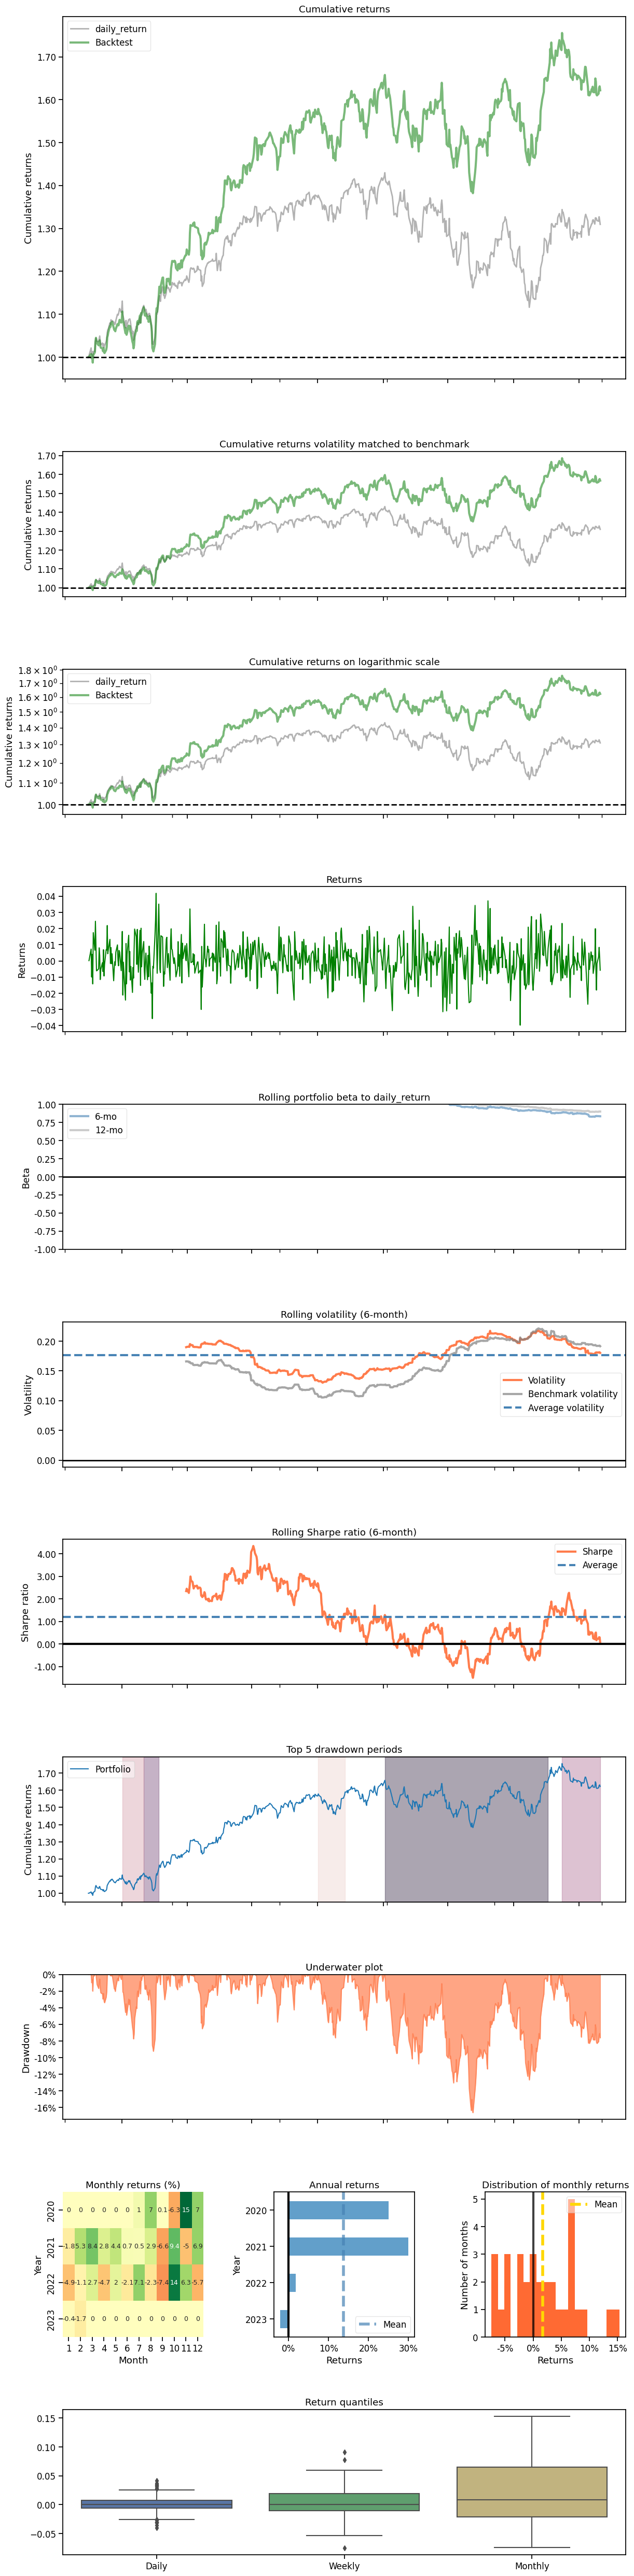

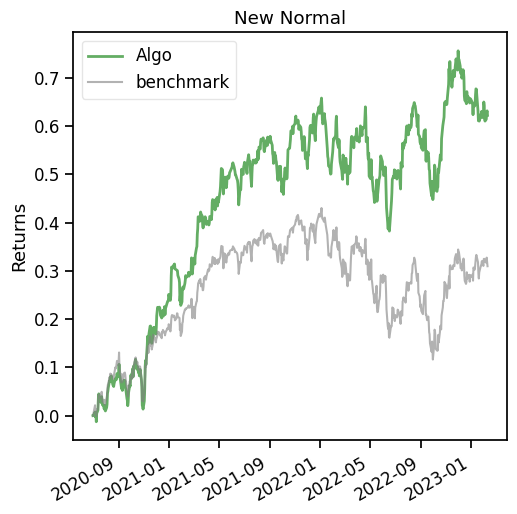

In [140]:
from copy import deepcopy
import pyfolio

def backtest_plot(
    account_value,
    baseline_start,
    baseline_end,
    baseline_ticker="^DJI",
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)

    baseline_df = get_baseline(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )

    baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d")
    baseline_df = pd.merge(df[["date"]], baseline_df, how="left", on="date")
    baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
    baseline_returns = get_daily_return(baseline_df, value_col_name="close")

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_sac, 
              baseline_ticker = '^DJI', 
              baseline_start = TRADE_START_DATE,
              baseline_end = TRADE_END_DATE)

